<a href="https://colab.research.google.com/github/claudiotancredi/mlinapptests/blob/main/Stage_1_MRCNN_RCGX12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022/DC03 Tool wear classification

### Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4dec3837-f590-526f-21cf-a8e8fbbb43e6)


### Clone GitHub repo

In [2]:
!git clone https://github.com/claudiotancredi/Machine-learning-in-applications

Cloning into 'mlinapptests'...
remote: Enumerating objects: 729, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 729 (delta 75), reused 62 (delta 25), pack-reused 584
Receiving objects: 100% (729/729), 131.86 MiB | 17.98 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Checking out files: 100% (184/184), done.


### Install dependencies

In [3]:
!pip install -r /content/mlinapptests/src/models/Stage1_Mask_RCNN/colab-requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 7.3 MB/s 
     |████████████████████████████████| 411.0 MB 39 kB/s 
     |████████████████████████████████| 312 kB 71.3 MB/s 
     |████████████████████████████████| 2.9 MB 56.3 MB/s 
     |████████████████████████████████| 26.5 MB 70.1 MB/s 
     |████████████████████████████████| 3.8 MB 60.8 MB/s 
     |████████████████████████████████| 503 kB 63.4 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=ec8f74e88865f27067e0c4f7dba72d169c0520325d02f263ec6ddd29294fc15c
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=45c011280e8e193c2111cc97fc57f46f13b45d5a84b3b36cc7810380228b3145
  Stored in directory: /root/.cache/

In [ ]:
#Check dependencies
import tensorflow as tf
print(tf.__version__)

1.15.3


### Initialization

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN/maskrcnn")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


... done downloading pretrained model!


### Mount Drive
It is supposed to include a "2022-DC03" path with "images.zip" of ALL the images.  
THIS NOTEBOOK NEEDS TO BE RUN AFTER THE BASELINE NOTEBOOKS, BECAUSE IT WILL USE THE SAME SPLIT EMPLOYED FOR THE BASELINE MODEL.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN", "logs")

### Prepare data on Drive
Annotations for the baseline model will be retrieved and translated so that only the WEAR category will be considered.
The cell with copy_images may take a while to run, so don't worry (and don't interrupt the execution!).  

In [7]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import prepare_folders

prepare_folders()

Working in Stage1_Mask_RCNN directory...
annotations folder didn't exist and has been created
images folder didn't exist and has been created
images/train folder didn't exist and has been created
images/val folder didn't exist and has been created
images/test folder didn't exist and has been created


In [8]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import translate_annotations

translate_annotations()

In [9]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import copy_images

copy_images("train")
copy_images("val")
copy_images("test")

Number of images for  train :  3751
Number of images for  val :  548
Number of images for  test :  1061


In [10]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import check_num_images

check_num_images()

Checking if the images in train, val and test folders of the Baseline
          model have been correctly copied for Stage 1 model. It's just a test to see
          if the translation of the annotations worked properly.
No errors have been encountered. You can proceed.


### Dataset

In [11]:
tool = "RCGX12"

DS_DIR = os.path.abspath("/content/mlinapptests/dataset")

sys.path.append(DS_DIR)

from WearDataset import WearDataset

# Root directory of images and annotations
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/")

# Training dataset
dataset_train = WearDataset()
dataset_train.load_wear(ROOT_DIR, "train", tool=tool)
dataset_train.prepare()

# Validation dataset
dataset_val = WearDataset()
dataset_val.load_wear(ROOT_DIR, "val", tool=tool)
dataset_val.prepare()

# Test dataset
dataset_test = WearDataset()
dataset_test.load_wear(ROOT_DIR, "test", tool=tool)
dataset_test.prepare()

augmentation = imgaug.augmenters.Sequential([imgaug.augmenters.Fliplr(0.5), imgaug.augmenters.Flipud(0.5), imgaug.augmenters.Affine(rotate=[0,90])])

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Number of nok:  164
Number of doubt:  158
Number of ok without cut because balanced=False:  2024
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of nok:  35
Number of doubt:  17
Number of ok without cut because balanced=False:  310
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of nok:  56
Number of doubt:  50
Number of ok without cut because balanced=False:  561


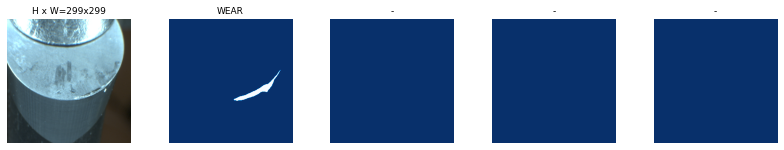

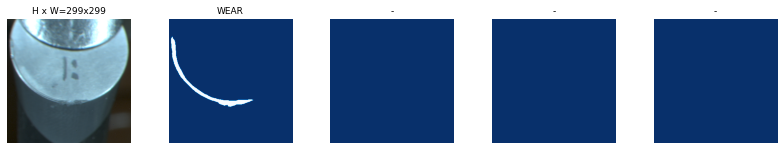

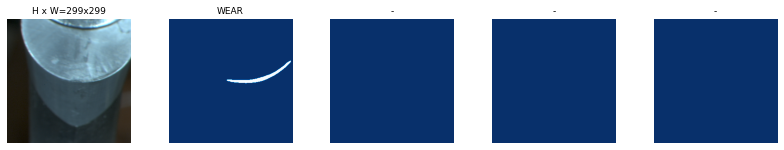

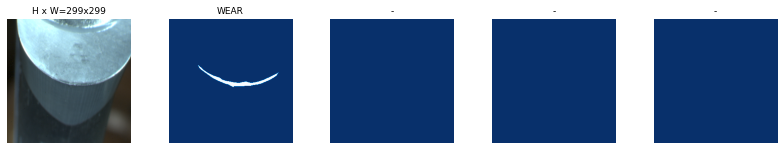

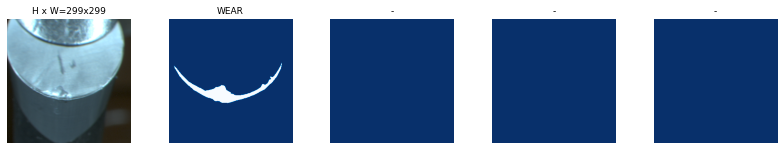

In [12]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_random_samples

visualize_random_samples(dataset_train, 5)

### Configurations

In [13]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from wearconfig import WearConfig

class RCGX12Config(WearConfig):
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 587 # 2346 images /4 = 586.5
    
RCGX12config = RCGX12Config()
RCGX12config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Create Model

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=RCGX12config,
                          model_dir=MODEL_DIR, tool=tool)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

### Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [16]:
%load_ext tensorboard

In [ ]:
import shutil
import glob

if os.path.exists("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/tblogs"):
  for match in glob.glob("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/tblogs/*"):
    shutil.rmtree(match)

In [17]:
# Training - Stage 1
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import keras
import datetime
print("Training network heads")
logdir=os.path.join("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/tblogs", tool+"_WEAR_STAGE1_MRCNN_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.train(dataset_train, dataset_val, 
            learning_rate=RCGX12config.LEARNING_RATE, 
            epochs=200, 
            layers='heads',
            augmentation=augmentation,
            custom_callbacks=[keras.callbacks.TensorBoard(logdir, update_freq="epoch"),
                              keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RCGX12_WEAR_STAGE1_MRCNN_20220713T1549/mask_rcnn_tool_wear.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2      

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/200
587/587 [==============================] - 260s 442ms/step - loss: 1.7671 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.8313 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.5976 - mrcnn_mask_loss: 0.2550 - val_loss: 1.6095 - val_rpn_class_loss: 0.0347 - val_rpn_bbox_loss: 0.7307 - val_mrcnn_class_loss: 0.0380 - val_mrcnn_bbox_loss: 0.5905 - val_mrcnn_mask_loss: 0.2157

Epoch 00001: val_loss improved from inf to 1.60953, saving model to /content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RCGX12_WEAR_STAGE1_MRCNN_20220713T1549/mask_rcnn_tool_wear.h5

Epoch 2/200
587/587 [==============================] - 213s 362ms/step - loss: 1.3940 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.6791 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.1680 - val_loss: 1.5068 - val_rpn_class_loss: 0.0325 - val_rpn_bbox_loss: 0.7544 - val_mrcnn_class_loss: 0.0559 - val_mrcnn_bbox_loss: 0.4985 - val_mrcnn_mask_loss: 0.1655

Epoch 00002: val_loss improved from 1.

In [18]:
# Training - Stage 3
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
import keras
import datetime
print("Fine tune all layers")
logdir=os.path.join("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/tblogs", tool+"_WEAR_STAGE1_MRCNN_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.load_weights(model.find_last(), by_name=True)
model.train(dataset_train, dataset_val, 
            learning_rate=RCGX12config.LEARNING_RATE / 10,
            epochs=400, 
            layers="all",
            augmentation=augmentation,
            custom_callbacks=[keras.callbacks.TensorBoard(logdir, update_freq="epoch"),
                              keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])
#patience should be around 10% of number of epochs

Fine tune all layers

Starting at epoch 62. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RCGX12_WEAR_STAGE1_MRCNN_20220713T1549/mask_rcnn_tool_wear.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_b

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multi

Epoch 63/400
587/587 [==============================] - 346s 589ms/step - loss: 0.8679 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4336 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.1330 - val_loss: 1.1729 - val_rpn_class_loss: 0.0139 - val_rpn_bbox_loss: 0.6891 - val_mrcnn_class_loss: 0.0444 - val_mrcnn_bbox_loss: 0.2673 - val_mrcnn_mask_loss: 0.1581

Epoch 00063: val_loss did not improve from 0.88553
Epoch 64/400
587/587 [==============================] - 284s 484ms/step - loss: 0.8597 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4362 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2578 - mrcnn_mask_loss: 0.1275 - val_loss: 1.1217 - val_rpn_class_loss: 0.0183 - val_rpn_bbox_loss: 0.6278 - val_mrcnn_class_loss: 0.0391 - val_mrcnn_bbox_loss: 0.2882 - val_mrcnn_mask_loss: 0.1483

Epoch 00064: val_loss did not improve from 0.88553
Epoch 65/400
587/587 [==============================] - 282s 481ms/step - loss: 0.8007 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [19]:
%tensorboard --logdir /content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/tblogs

### Detection

In [20]:
class InferenceConfig(RCGX12Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

inference_config = InferenceConfig()
inference_config.display()

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR, tool=tool)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
#CHANGE MODEL_PATH MANUALLY EVERY TIME PLEASE

# Load trained weights
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

#### Visualize ground truth

Image name:  RCGX12_GMTK1_20211021_006604_wo_cn.bmp
original_image           shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  320.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    3.00000  max:  209.00000  int32
gt_mask                  shape: (320, 320, 2)         min:    0.00000  max:    1.00000  bool


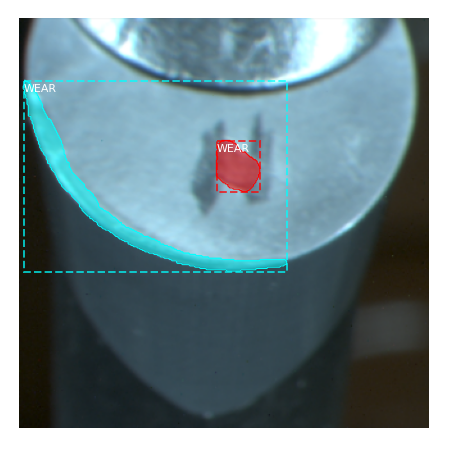

In [21]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_gt

image_id = visualize_gt(dataset_test, inference_config, 3)

#### Visualize predictions

Image name:  RCGX12_GMTK1_20211021_006604_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


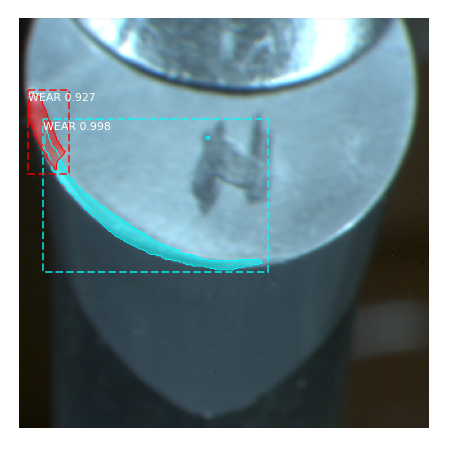

In [22]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model)

##### Adjust bboxes
Bboxes are not accurate and include portions that may not be of our interest. Here we try to find more accurate bboxes starting from masks.

Image name:  RCGX12_GMTK1_20211021_006604_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


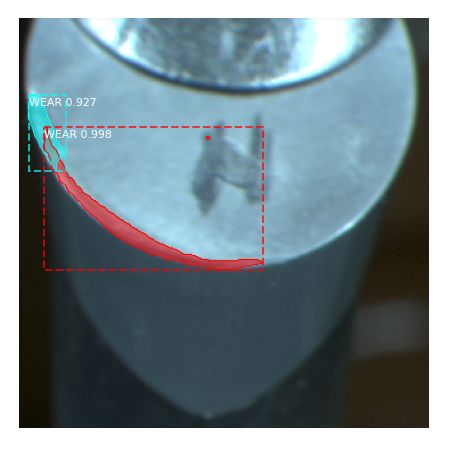

In [23]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model, adjusted=True)

Bboxes are better now.

## Evaluation

In [24]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import compute_map

compute_map(dataset_test, inference_config, model)

mAP: 0.789


### Save info in a JSON file for stage 2 (classifier)


*   This part takes into account masks areas and scores in order to find the largest mask whose confidence is greater than a certain threshold.
*   The saved JSON file can be used in the stage 2 if we want to visualize the image, the bbox and the final prediction for the image.
*   Predictions are done also on the **training set**! It is conceptually wrong but in our case it could be necessary and okay.
* Images are stored again on GDrive after cropping.

Working on training set...
wo
Image name:  RCGX12_GMTK2_20211103_010556_wo_cc.bmp
Number of images in training set:  2346
Number of images in training set for which at least one confident (>= 0.95 ) mask has been predicted:  2327

Working also on validation set...
wo
Image name:  RCGX12_GMTK2_20211103_010038_wo_cc.bmp
Number of images in validation set:  362
Number of images in validation set for which at least one confident (>= 0.95 ) mask has been predicted:  357

Working also on test set...
wo
Image name:  RCGX12_GMTK2_20211103_010374_wo_cc.bmp
Number of images in test set:  667
Number of images in test set for which at least one mask has been predicted:  667
Number of images in test set for which no masks have been predicted, and therefore have  not been cropped and passed down to 2nd stage, but have been only added to the JSON,  so that the 2nd stage can consider them directly as OK, as if the prediction was entirely  performed by the 1st stage:  0
Example of JSON object:  {'name'

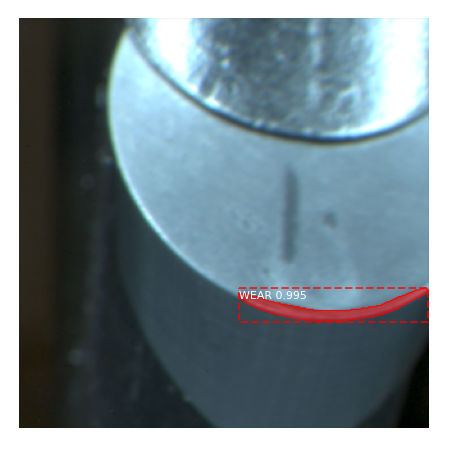

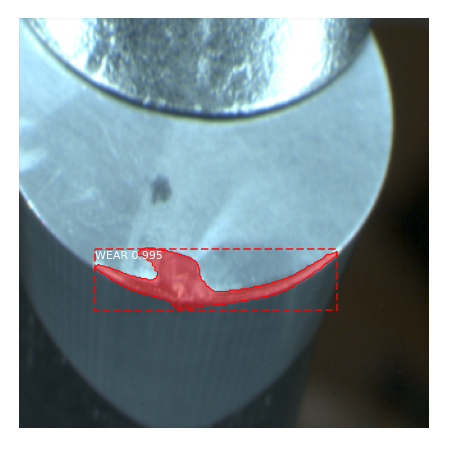

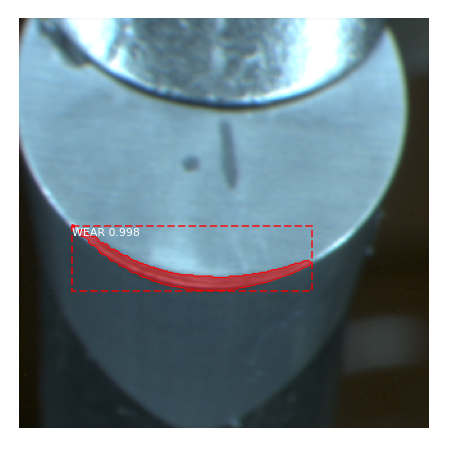

In [26]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import predict_and_prepare_data_for_s2

predict_and_prepare_data_for_s2(dataset_train, dataset_val, dataset_test, inference_config, model, tool, threshold=0.95, visual=True)